In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class RBM(object):
    def __init__(self, m, n):
        """
        m: Number of neurons in visible layer
        n: number of neurons in hidden layer
        """
        self._m = m
        self._n = n
                
        
        
        # Create the Computational graph
       
        # Weights and biases
        self._W = tf.Variable(tf.random_normal(shape=(self._m,self._n)))
        self._c = tf.Variable(np.zeros(self._n).astype(np.float32))  #bias for hidden layer
        self._b = tf.Variable(np.zeros(self._m).astype(np.float32))  #bias for Visible layer
            
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._m])
                                               
        # Forwards Pass
        _h = tf.nn.sigmoid(tf.matmul(self._X, self._W) + self._c)
        self.h = tf.nn.relu(tf.sign(_h - tf.random_uniform(tf.shape(_h))))
                      
            
        #Backward pass
        _v = tf.nn.sigmoid(tf.matmul(self.h, tf.transpose(self._W)) + self._b)
        self.V = tf.nn.relu(tf.sign(_v - tf.random_uniform(tf.shape(_v))))
                        
                                              
        # Objective Function
        objective = tf.reduce_mean(self.free_energy(self._X)) - tf.reduce_mean(
                              self.free_energy(self.V))
        self._train_op =  tf.train.GradientDescentOptimizer(1e-3).minimize(objective)
        
        # Cross entropy cost
        reconstructed_input = self.one_pass(self._X)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self._X, logits=reconstructed_input))

            
            
    def set_session(self, session):
        self.session = session
            
                                   
            
    def free_energy(self, V):
        b = tf.reshape(self._b, (self._m, 1))
        term_1 = -tf.matmul(V,b)
        term_1 = tf.reshape(term_1, (-1,))
        
        term_2 = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V,self._W) + self._c))
        return term_1 + term_2
    
    def one_pass(self, X):
        h = tf.nn.sigmoid(tf.matmul(X, self._W) + self._c)
        return tf.matmul(h, tf.transpose(self._W)) + self._b
    
    def reconstruct(self,X):
        x = tf.nn.sigmoid(self.one_pass(X))
        return self.session.run(x, feed_dict={self._X: X})
        
        
        
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        
        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._train_op,self.cost ], feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format(i,ob, j)) 
                obj.append(ob)
        return obj

In [4]:
Xtrain = trX.astype(np.float32)
Xtest = teX.astype(np.float32)
_, m = Xtrain.shape

rbm = RBM(m, 600)

#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    rbm.set_session(sess)
    err = rbm.fit(Xtrain, epochs=3)
    out = rbm.reconstruct(Xtest[0:100])

training epoch 0 batch 0 cost 6.004464149475098
training epoch 0 batch 100 cost 0.25257736444473267
training epoch 0 batch 200 cost 0.21343500912189484
training epoch 0 batch 300 cost 0.20747235417366028
training epoch 0 batch 400 cost 0.18498995900154114
training epoch 0 batch 500 cost 0.18456442654132843
training epoch 1 batch 0 cost 0.17866669595241547
training epoch 1 batch 100 cost 0.1647292673587799
training epoch 1 batch 200 cost 0.159803107380867
training epoch 1 batch 300 cost 0.16542433202266693
training epoch 1 batch 400 cost 0.15586064755916595
training epoch 1 batch 500 cost 0.15928760170936584
training epoch 2 batch 0 cost 0.15671007335186005
training epoch 2 batch 100 cost 0.14797250926494598
training epoch 2 batch 200 cost 0.14541533589363098
training epoch 2 batch 300 cost 0.15265730023384094
training epoch 2 batch 400 cost 0.14485737681388855
training epoch 2 batch 500 cost 0.15023769438266754


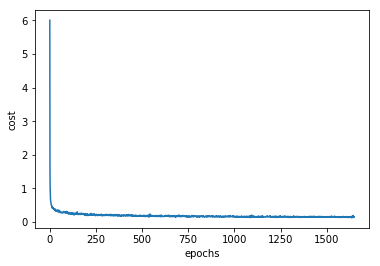

In [5]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')

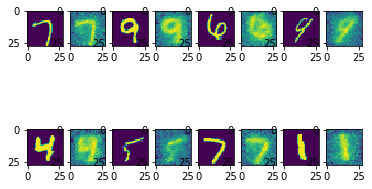

In [6]:
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col)

j, k = 0,0
for i in idx:
    axarr[j,k].imshow(Xtest[i].reshape(28,28))
    axarr[j,k+1].imshow(out[i].reshape(28,28))
    k = k+2
    if k==col:
        j,k=1, 0